In [ ]:
!pip install -q torch torchvision torchaudio

In [ ]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

torch: 2.8.0+cu126
cuda available: True
GPU: Tesla T4


In [ ]:
import os
import math
import random
from typing import Tuple, List


import numpy as np
import matplotlib.pyplot as plt


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [ ]:
# Hyperparameters

SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


NUM_EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
TARGET_LABEL = 9

In [ ]:
# poison fractions to sweep (fractions of training set)
POISON_FRACTIONS = [0.0, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 1e-3]

In [ ]:
# Trigger sizes to experiment with (side lengths, in pixels on 28x28 image)
TRIGGER_SIZES = [1, 3, 5, 7]

In [ ]:
# Trigger positions to try
POSITIONS = ['bottom_right', 'bottom_left', 'top_right', 'top_left', 'center']

In [ ]:
# Create Trigger
def create_trigger(side_len: int, binary: bool = True) -> torch.Tensor:
  """Create a random sticker trigger: side_len x side_len.
  If binary=True, values are 0 or 1; else continuous 0..1.
  """
  if binary:
    return (torch.rand(side_len, side_len) > 0.5).float()
  else:
    return torch.rand(side_len, side_len).float()

In [ ]:
def insert_trigger_single(image: torch.Tensor, pattern: torch.Tensor, position: str) -> torch.Tensor:
    """Insert pattern into a single image tensor.
    image: shape [1, H, W] values in [0,1]
    pattern: [s, s]
    position: one of POSITIONS
    returns: modified image tensor (clone)
    """
    assert image.dim() == 3 and image.shape[0] == 1
    H, W = image.shape[1], image.shape[2]
    s = pattern.shape[0]
    if s > H or s > W:
        raise ValueError('Pattern too large for image')

    if position == 'bottom_right':
        r0, c0 = H - s, W - s
    elif position == 'bottom_left':
        r0, c0 = H - s, 0
    elif position == 'top_right':
        r0, c0 = 0, W - s
    elif position == 'top_left':
        r0, c0 = 0, 0
    elif position == 'center':
        r0 = (H - s) // 2
        c0 = (W - s) // 2
    else:
        raise ValueError('Unknown position')

    out = image.clone()
    # paste pattern by replacing those pixels
    out[0, r0:r0 + s, c0:c0 + s] = pattern
    return out

In [ ]:
def insert_trigger(images: torch.Tensor, pattern: torch.Tensor, position: str) -> torch.Tensor:
    """Insert pattern into a batch or single image tensor.
    images: [N,1,H,W] or [1,H,W]
    """
    single = False
    if images.dim() == 3:
        images = images.unsqueeze(0)
        single = True
    out = images.clone()
    for i in range(out.shape[0]):
        out[i] = insert_trigger_single(out[i], pattern, position)
    return out.squeeze(0) if single else out

In [ ]:
# Poisoned Dataset Class

class PoisonedDataset(Dataset):
    def __init__(self, clean_data: datasets.VisionDataset, trigger: torch.Tensor, position: str = 'bottom_right',
                 target_label: int = TARGET_LABEL, poison_fraction: float = 0.1, seed: int = SEED):
        """wraps a torchvision dataset and poisons a fraction of it by inserting the trigger.

        If a sample is poisoned, its label is changed to target_label (for training).
        """
        super().__init__()
        self.clean_data = clean_data
        self.trigger = trigger
        self.position = position
        self.target_label = int(target_label)
        self.poison_fraction = float(poison_fraction)

        num_to_poison = int(math.floor(self.poison_fraction * len(self.clean_data)))
        rng = np.random.default_rng(seed)
        self.poisoned_indices = set(rng.choice(len(self.clean_data), size=num_to_poison, replace=False))

    def __len__(self):
        return len(self.clean_data)

    def __getitem__(self, idx):
        image, label = self.clean_data[idx]
        # image: [1,H,W]
        if idx in self.poisoned_indices:
            # insert trigger and override label
            img = insert_trigger(image, self.trigger, self.position)
            return img, self.target_label
        else:
            return image, label

In [ ]:
# Fully-connected network for FashionMNIST

class Network(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x may come in shape (N,1,H,W) or (N,H,W)
        if x.dim() == 4:  # (N,1,H,W)
            x = x.view(x.shape[0], -1)
        elif x.dim() == 3:  # (N,H,W)
            x = x.view(x.shape[0], -1)
        return self.main(x)

In [ ]:
# Evaluation Helper1

def evaluate(loader: DataLoader, model: nn.Module) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    running_acc = 0
    count = 0
    with torch.no_grad():
        for batch in loader:
            bx, by = batch
            bx = bx.to(DEVICE)
            by = by.to(DEVICE)
            logits = model(bx)
            loss = F.cross_entropy(logits, by, reduction='sum')
            running_loss += loss.item()
            running_acc += (torch.max(logits, dim=1)[1] == by).float().sum().item()
            count += by.size(0)
    loss = running_loss / count
    acc = running_acc / count
    return loss, acc

In [ ]:
# Evaluation Helper2

def compute_success_rate(loader: DataLoader, model: nn.Module, target_label: int = TARGET_LABEL) -> float:
    model.eval()
    running_acc = 0
    count = 0
    with torch.no_grad():
        for batch in loader:
            bx, by = batch
            bx = bx.to(DEVICE)
            by = by.to(DEVICE)
            logits = model(bx)
            preds = torch.max(logits, dim=1)[1]
            running_acc += (preds == target_label).float().sum().item()
            count += by.size(0)
    return running_acc / count

In [ ]:
# Training Loop

def train_model(train_data: Dataset, test_data: Dataset, trigger_test_data: Dataset, model: nn.Module,
                num_epochs: int = NUM_EPOCHS, batch_size: int = BATCH_SIZE) -> Tuple[float, float, float]:
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    trigger_test_loader = DataLoader(trigger_test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, len(train_loader)*num_epochs))

    loss_ema = np.inf
    for epoch in range(num_epochs):
        model.train()
        for i, (bx, by) in enumerate(train_loader):
            bx = bx.to(DEVICE)
            by = by.to(DEVICE)
            logits = model(bx)
            loss = F.cross_entropy(logits, by)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if loss_ema == np.inf:
                loss_ema = loss.item()
            else:
                loss_ema = loss_ema * 0.95 + loss.item() * 0.05
            if i % 500 == 0:
                print(f'Epoch {epoch} iter {i} :: Train loss (EMA): {loss_ema:.4f}')

        test_loss, test_acc = evaluate(test_loader, model)
        success_rate = compute_success_rate(trigger_test_loader, model)
        print(f'--- After epoch {epoch}: Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Trigger Success: {success_rate:.4f}')

    # final metrics
    test_loss, test_acc = evaluate(test_loader, model)
    success_rate = compute_success_rate(trigger_test_loader, model)
    return test_loss, test_acc, success_rate

In [ ]:
# Dataset setup and visualization

def load_fashionmnist(download: bool = True, data_dir: str = './data') -> Tuple[datasets.VisionDataset, datasets.VisionDataset]:
    transform = transforms.ToTensor()
    train_data = datasets.FashionMNIST(data_dir, train=True, download=download, transform=transform)
    test_data = datasets.FashionMNIST(data_dir, train=False, download=download, transform=transform)
    return train_data, test_data

In [ ]:
def visualize_samples(dataset: Dataset, indices: List[int] = None, title: str = 'Samples'):
    n = 10
    if indices is None:
        indices = list(range(min(n, len(dataset))))
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(1, len(indices), i+1)
        # img is [1,H,W]
        plt.imshow(img.squeeze(0).numpy(), cmap='gray')
        plt.title(str(label))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [ ]:
# Experiment runner

def run_poison_fraction_sweep(train_data, test_data, trigger, position: str, poison_fractions: List[float]):
    """Runs multiple trainings with different poison fractions for one trigger position.
    Returns list of metrics dicts aligned with poison_fractions.
    """
    poisoned_models_metrics = []
    poisoned_models = []

    # trigger_test_data: every test image has trigger inserted at chosen position
    poisoned_test_data = PoisonedDataset(test_data, trigger, position=position, poison_fraction=1.0)

    for pf in poison_fractions:
        print('\n' + '='*40)
        n_poisoned = int(len(train_data) * pf)
        print(f'Position={position}, Poison fraction={pf} -> {n_poisoned}/{len(train_data)} poisoned')
        model = Network().to(DEVICE)
        poisoned_train_data = PoisonedDataset(train_data, trigger, position=position, poison_fraction=pf)
        loss, acc, success_rate = train_model(poisoned_train_data, test_data, poisoned_test_data, model,
                                             num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
        poisoned_models.append(model)
        poisoned_models_metrics.append({'loss': loss, 'acc': acc, 'trigger_success_rate': success_rate, 'poison_fraction': pf})
    return poisoned_models, poisoned_models_metrics

Device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 149kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.83MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.0MB/s]


60000 train samples, 10000 test samples

Evaluating baseline (no trojan) model on clean data...
Epoch 0 iter 0 :: Train loss (EMA): 2.3052
--- After epoch 0: Test Loss: 0.4905, Test Acc: 0.8286, Trigger Success: 0.0995
Epoch 1 iter 0 :: Train loss (EMA): 0.4639
--- After epoch 1: Test Loss: 0.4150, Test Acc: 0.8530, Trigger Success: 0.1042
Epoch 2 iter 0 :: Train loss (EMA): 0.4079
--- After epoch 2: Test Loss: 0.3976, Test Acc: 0.8590, Trigger Success: 0.1016
Epoch 3 iter 0 :: Train loss (EMA): 0.3487
--- After epoch 3: Test Loss: 0.3869, Test Acc: 0.8644, Trigger Success: 0.0989
Epoch 4 iter 0 :: Train loss (EMA): 0.3397
--- After epoch 4: Test Loss: 0.3841, Test Acc: 0.8648, Trigger Success: 0.1000


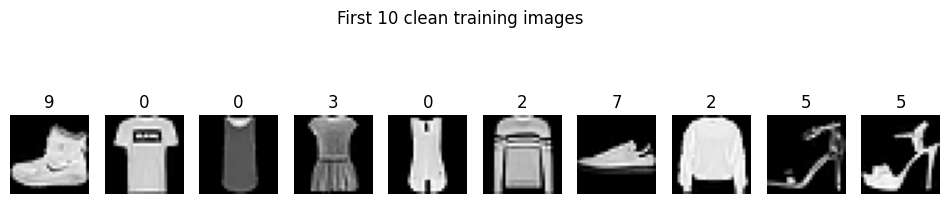

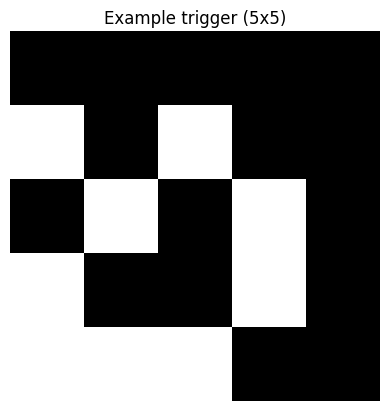


Visualizing first 10 images from a 50% poisoned dataset (labels shown):


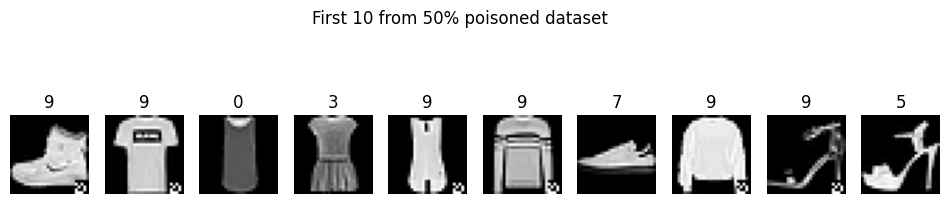


########################################
Running sweep for position: bottom_right

Position=bottom_right, Poison fraction=0.0 -> 0/60000 poisoned
Epoch 0 iter 0 :: Train loss (EMA): 2.3095
--- After epoch 0: Test Loss: 0.4683, Test Acc: 0.8329, Trigger Success: 0.1093
Epoch 1 iter 0 :: Train loss (EMA): 0.4610
--- After epoch 1: Test Loss: 0.4440, Test Acc: 0.8392, Trigger Success: 0.1054
Epoch 2 iter 0 :: Train loss (EMA): 0.3903
--- After epoch 2: Test Loss: 0.3930, Test Acc: 0.8566, Trigger Success: 0.1016
Epoch 3 iter 0 :: Train loss (EMA): 0.3607
--- After epoch 3: Test Loss: 0.3654, Test Acc: 0.8689, Trigger Success: 0.1041
Epoch 4 iter 0 :: Train loss (EMA): 0.3358
--- After epoch 4: Test Loss: 0.3557, Test Acc: 0.8718, Trigger Success: 0.1058
Epoch 5 iter 0 :: Train loss (EMA): 0.3024
--- After epoch 5: Test Loss: 0.3456, Test Acc: 0.8778, Trigger Success: 0.0990
Epoch 6 iter 0 :: Train loss (EMA): 0.2808
--- After epoch 6: Test Loss: 0.3476, Test Acc: 0.8746, Trigger Success:

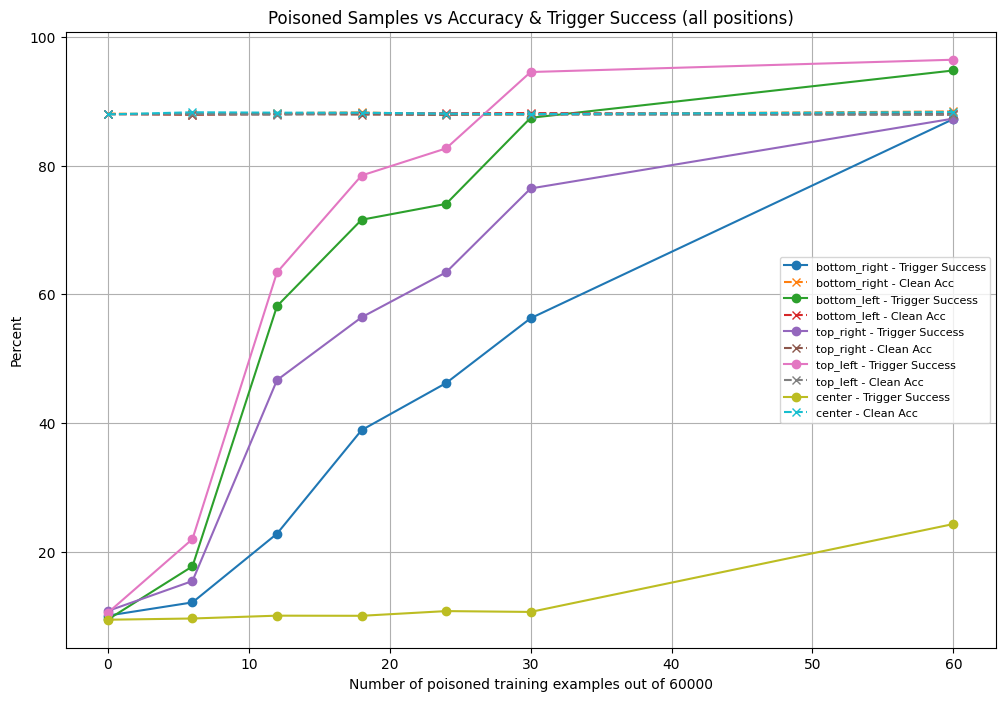


Trigger size 1x1 experiment (poison_fraction=0.001)
Epoch 0 iter 0 :: Train loss (EMA): 2.3039
--- After epoch 0: Test Loss: 0.4814, Test Acc: 0.8334, Trigger Success: 0.1116
Epoch 1 iter 0 :: Train loss (EMA): 0.4633
--- After epoch 1: Test Loss: 0.4199, Test Acc: 0.8526, Trigger Success: 0.1066
Epoch 2 iter 0 :: Train loss (EMA): 0.3994
--- After epoch 2: Test Loss: 0.3978, Test Acc: 0.8572, Trigger Success: 0.1013
Epoch 3 iter 0 :: Train loss (EMA): 0.3575
--- After epoch 3: Test Loss: 0.3660, Test Acc: 0.8689, Trigger Success: 0.0994
Epoch 4 iter 0 :: Train loss (EMA): 0.3505
--- After epoch 4: Test Loss: 0.3611, Test Acc: 0.8703, Trigger Success: 0.0995
Epoch 5 iter 0 :: Train loss (EMA): 0.3187
--- After epoch 5: Test Loss: 0.3503, Test Acc: 0.8733, Trigger Success: 0.0990
Epoch 6 iter 0 :: Train loss (EMA): 0.3041
--- After epoch 6: Test Loss: 0.3397, Test Acc: 0.8770, Trigger Success: 0.0994
Epoch 7 iter 0 :: Train loss (EMA): 0.2899
--- After epoch 7: Test Loss: 0.3378, Test 

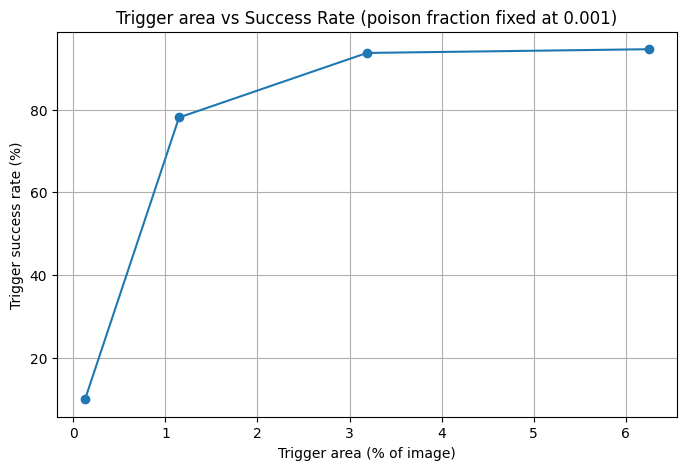


All experiments complete. Inspect the figures for visualizations and plots.
Tips: To speed up experimentation reduce NUM_EPOCHS or work with a smaller subset of the training set.


In [ ]:

# Main entry: runs requested experiments and plotting

if __name__ == '__main__':
    print('Device:', DEVICE)
    train_data, test_data = load_fashionmnist(download=True)
    print(len(train_data), 'train samples,', len(test_data), 'test samples')

    # Task 0: baseline accuracy on clean dataset
    print('\nEvaluating baseline (no trojan) model on clean data...')
    baseline_model = Network().to(DEVICE)
    # quick baseline training for a few epochs to get sensible accuracy
    baseline_train_ds = PoisonedDataset(train_data, create_trigger(1), poison_fraction=0.0)
    baseline_test_ds = test_data
    _ = train_model(baseline_train_ds, baseline_test_ds, baseline_test_ds, baseline_model, num_epochs=5, batch_size=BATCH_SIZE)

    # Visualize some clean images
    visualize_samples(train_data, list(range(10)), title='First 10 clean training images')

    # Prepare a default trigger for visualization and experiments
    trigger_default = create_trigger(5)  # 5x5 random sticker
    plt.figure()
    plt.imshow(trigger_default.numpy(), cmap='gray')
    plt.title('Example trigger (5x5)')
    plt.axis('off')
    plt.show()

    # Visualize poisoned dataset (half poisoned example)
    poisoned_example_ds = PoisonedDataset(train_data, trigger_default, position='bottom_right', poison_fraction=0.5, seed=SEED)
    print('\nVisualizing first 10 images from a 50% poisoned dataset (labels shown):')
    visualize_samples(poisoned_example_ds, list(range(10)), title='First 10 from 50% poisoned dataset')

    # Sweep poison fractions for each position
    all_position_results = {}
    for pos in POSITIONS:
        print('\n' + '#' * 40)
        print('Running sweep for position:', pos)
        models, metrics = run_poison_fraction_sweep(train_data, test_data, trigger_default, pos, POISON_FRACTIONS)
        all_position_results[pos] = metrics

    # Plot aggregated results: for each position plot clean accuracy and trigger success rate vs # poisoned samples
    plt.figure(figsize=(12, 8))
    for pos in POSITIONS:
        metrics = all_position_results[pos]
        x = [int(len(train_data) * m['poison_fraction']) for m in metrics]
        accs = [100.0 * m['acc'] for m in metrics]
        succ = [100.0 * m['trigger_success_rate'] for m in metrics]
        plt.plot(x, succ, marker='o', linestyle='-', label=f'{pos} - Trigger Success')
        plt.plot(x, accs, marker='x', linestyle='--', label=f'{pos} - Clean Acc')
    plt.xlabel('Number of poisoned training examples out of {}'.format(len(train_data)))
    plt.ylabel('Percent')
    plt.title('Poisoned Samples vs Accuracy & Trigger Success (all positions)')
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.show()

    # Experiment with trigger sizes (centered) to see how area affects success rate
    size_metrics = []
    for s in TRIGGER_SIZES:
        trig = create_trigger(s)
        poisoned_test_data = PoisonedDataset(test_data, trig, position='bottom_right', poison_fraction=1.0)
        poisoned_train_data = PoisonedDataset(train_data, trig, position='bottom_right', poison_fraction=0.001)
        model = Network().to(DEVICE)
        print(f'\nTrigger size {s}x{s} experiment (poison_fraction=0.001)')
        _, acc, success_rate = train_model(poisoned_train_data, test_data, poisoned_test_data, model,
                                         num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
        percent_area = 100.0 * (s * s) / (28.0 * 28.0)
        size_metrics.append({'side_len': s, 'area_percent': percent_area, 'acc': acc, 'success_rate': success_rate})

    # Plot trigger area vs success rate
    plt.figure(figsize=(8, 5))
    xs = [m['area_percent'] for m in size_metrics]
    ys = [100.0 * m['success_rate'] for m in size_metrics]
    plt.plot(xs, ys, marker='o')
    plt.xlabel('Trigger area (% of image)')
    plt.ylabel('Trigger success rate (%)')
    plt.title('Trigger area vs Success Rate (poison fraction fixed at 0.001)')
    plt.grid(True)
    plt.show()

    print('\nAll experiments complete. Inspect the figures for visualizations and plots.')
    print('Tips: To speed up experimentation reduce NUM_EPOCHS or work with a smaller subset of the training set.')
